# 필요 모듈 설치 및 임포트 & TPU 설정

In [34]:
!pip install transformers
!pip install tensorflow_addons

In [35]:
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from transformers import BertTokenizer, TFBertModel
from transformers import AutoTokenizer, AutoModel, TFAutoModel

import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.regularizers import l1_l2


In [36]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import tensorflow_addons as tfa

In [190]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [192]:
from google.colab import files
files.download("/content/best_model_1128_adamw_10epochs_ver2.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [37]:
%tensorflow_version 2.x
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Colab only includes TensorFlow 2.x; %tensorflow_version has no effect.
Found GPU at: /device:GPU:0


In [ ]:
resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' + os.environ['COLAB_TPU_ADDR'])

tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)

strategy = tf.distribute.TPUStrategy(resolver)

KeyError: ignored

# 데이터 불러오고 확인

In [38]:
# 데이터 불러오기
data = pd.read_csv('/content/1120데이터.csv')
del data['Unnamed: 0']
# del data["Dalogue"]

# 라벨링 된 데이터만 불러오기
data = data.dropna()
data

,Emotion,Dalogue_stopwords
0,0,햇살 가득한 아침 눈 뜨니 기분 좋아
1,0,작은 꽃 송이 피어 나 마음 따뜻해졌어
2,0,오랜 만 친구 들 모 여서 웃으면서 행복한 보냈어
3,0,산책 하면서 새롭게 발견 공원 아름답고 기분 좋게 만들어줘
4,0,가족 함께 저녁 식사 하면서 나눈 이야기 소중한 이야
...,...,...
86525,3,기분 드럽네
86526,3,머리 나쁘네
86527,3,호구냐 참
86528,3,눈치 없어서 모르나 본데


In [13]:
data["Emotion"].unique()

array([0, 1, 3, 4, 5, 2])

In [14]:
data["Emotion"].value_counts()

2    30360
3    20568
4    16460
0    12661
5     5503
1      977
Name: Emotion, dtype: int64

In [ ]:
data["Emotion"].value_counts()

2    31667
3    20501
4    15204
0    12712
5     5495
1      833
Name: Emotion, dtype: int64

# 함수 지정 및 모델 설정

In [87]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.25
MAX_LEN = 64 # EDA에서 추출된 Max Length

In [88]:
tokenizer = BertTokenizer.from_pretrained("bert-base-multilingual-cased", cache_dir='bert_ckpt', do_lower_case=False)

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("Definite/kobert-finetuned-klue-ner-finetuned-bible", cache_dir='bert_ckpt', do_lower_case=False)

In [89]:
test_sentence = "밥도 잘 먹질 못 해 네가 생각 날 까봐"

encode = tokenizer.encode(test_sentence)
token_print = [tokenizer.decode(token) for token in encode]

print(encode)
print(token_print)

[101, 9327, 12092, 9654, 9266, 48599, 9290, 9960, 9011, 11287, 9420, 66540, 8985, 8939, 118990, 102]
['[ C L S ]', '밥', '# # 도', '잘', '먹', '# # 질', '못', '해', '네', '# # 가', '생', '# # 각', '날', '까', '# # 봐', '[ S E P ]']


In [90]:
# Bert Tokenizer
def bert_tokenizer(sent, MAX_LEN):

    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.

    )

    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences

    return input_id, attention_mask, token_type_id

In [91]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in tqdm(zip(data["Dalogue_stopwords"], data["Emotion"]), total=len(data)):
    try:
        input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        train_data_labels.append(train_label)

    except Exception as e:
        print(e)
        print(train_sent)
        pass

train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("# sents: {}, # labels: {}".format(len(train_movie_input_ids), len(train_data_labels)))

100%|██████████| 86529/86529 [00:17<00:00, 4818.14it/s]


# sents: 86529, # labels: 86529


In [92]:
input_id = train_movie_input_ids[1]
attention_mask = train_movie_attention_masks[1]
token_type_id = train_movie_type_ids[1]

print(input_id)
print(attention_mask)
print(token_type_id)
print(tokenizer.decode(input_id))

[   101  57429   8959   9454  10739   9946  12965   8982   9246  32158
   9130 118848  14523 119210  12965    102      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
[CLS] 작은 꽃 송이 피어 나 마음 따뜻해졌어 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [45]:
with tf.device('/device:GPU:0'):
    class TFBertClassifier(tf.keras.Model):
        def __init__(self, model_name, dir_path):
            super(TFBertClassifier, self).__init__()

            # BERT 모델 로드
            self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)

            # 드롭아웃 레이어
            self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)

            # 추가 중간 밀집 레이어
            self.dense1 = tf.keras.layers.Dense(units=128, activation='relu')

            # 배치 정규화 레이어
            self.batch_norm = tf.keras.layers.BatchNormalization()

            # 추가 드롭아웃 레이어
            self.dropout2 = tf.keras.layers.Dropout(rate=0.5)

            # 최종 분류기 레이어
            self.classifier = tf.keras.layers.Dense(
                6,
                activation='softmax',
                kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                name="classifier"
            )

        def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
            # BERT 모델을 통한 출력
            outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
            sequence_output = outputs[0]
            pooled_output = outputs[1]

            # 드롭아웃 적용
            pooled_output = self.dropout(pooled_output, training=training)

            # 추가 중간 밀집 레이어 적용
            middle_output = self.dense1(pooled_output)

            # 배치 정규화 적용
            middle_output = self.batch_norm(middle_output, training=training)

            # 추가 드롭아웃 적용
            middle_output = self.dropout2(middle_output, training=training)

            # 최종 분류기 레이어를 통한 로짓
            logits = self.classifier(middle_output)

            return logits

In [93]:
# with strategy.scope():
with tf.device('/device:GPU:0'):
    # BERT 기반의 텍스트 분류 모델 클래스 정의
    class TFBertClassifier(tf.keras.Model):
        def __init__(self, model_name, dir_path):
            super(TFBertClassifier, self).__init__()
            # BERT 모델을 초기화 하고 사전 학습된 모델을 불러오기
            self.bert = TFBertModel.from_pretrained(model_name, cache_dir=dir_path)
            # 드롭아웃 레이어 추가. BERT 모델의 hidden_dropout_prob 값 사용.
            self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
            # 출력을 위한 레이어를 추가 6개의 클래스로 분류.
            self.classifier = tf.keras.layers.Dense(6, activation='softmax',
                                                    kernel_initializer=tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range),
                                                    name="classifier")
        # 모델 설정을 반환하는 함수. 나중에 모델을 저장하고 재사용하기 위함.
        def get_config(self):
            config = super().get_config().copy()
            config.update({
                'bert': self.bert,
                'dropout': self.dropout,
                'classifier': self.classifier,
            })
            return config
        # 호출 함수를 정의. 함수는 모델이 입력 데이터를 어떻게 처리할지 결정함.
        def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
            # BERT 모델로부터 출력을 받아옴. 여기서는 pooled_output(집계된 출력)을 사용함.
            outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
            pooled_output = outputs[1]  # BERT의 두 번째 출력은 pooled_output.
            # 드롭아웃을 적용. training 파라미터는 훈련 중인지 나타냄.
            pooled_output = self.dropout(pooled_output, training=training)
            # 분류 레이어를 통과해 최종 로짓
            logits = self.classifier(pooled_output)
            return logits

In [94]:
sentiment_model = TFBertClassifier(model_name='bert-base-multilingual-cased',
                                  dir_path='bert_ckpt')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [23]:
# sentiment_model = TFBertClassifier(model_name='Definite/kobert-finetuned-klue-ner-finetuned-bible',
#                                   dir_path='bert_ckpt')

In [95]:
MIN_DELTA = 1e-3
PATIENCE = 5

early_stopping = EarlyStopping(
    monitor = "accuracy",
    min_delta = MIN_DELTA,
    patience = PATIENCE)

# 최고 성능의 모델 파일을 저장할 이름과 경로 설정
BEST_MODEL_NAME = '/content/checkpoint/best_model_1128_5epoch_adamw_ver2.h5'
model_checkpoint = ModelCheckpoint(
    filepath = BEST_MODEL_NAME,
    save_weights_only=True,
    monitor = "accuracy",
    mode = "min",
    save_best_only = True, # 성능 향상 시에만 모델 저장
    verbose = 1
)

callbacks = [early_stopping, model_checkpoint]

# 모델 훈련 및 평가

In [96]:
# AdamW 옵티마이저 사용
import tensorflow_addons as tfa

opt = tfa.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4, epsilon=1e-8)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
sentiment_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

In [119]:
# 모델 학습
history = sentiment_model.fit(
    train_movie_inputs, train_data_labels,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALID_SPLIT,
    callbacks=callbacks
)

# 학습 이력 출력
print(history.history)

Epoch 1/5
507/507 [==============================] - ETA: 0s - loss: 0.4888 - accuracy: 0.8083
Epoch 1: accuracy did not improve from 0.68807
507/507 [==============================] - 204s 403ms/step - loss: 0.4888 - accuracy: 0.8083 - val_loss: 5.7030 - val_accuracy: 0.1610
Epoch 2/5
507/507 [==============================] - ETA: 0s - loss: 0.4859 - accuracy: 0.8100
Epoch 2: accuracy did not improve from 0.68807
507/507 [==============================] - 204s 403ms/step - loss: 0.4859 - accuracy: 0.8100 - val_loss: 5.7201 - val_accuracy: 0.1568
Epoch 3/5
507/507 [==============================] - ETA: 0s - loss: 0.4826 - accuracy: 0.8104
Epoch 3: accuracy did not improve from 0.68807
507/507 [==============================] - 204s 403ms/step - loss: 0.4826 - accuracy: 0.8104 - val_loss: 5.7268 - val_accuracy: 0.1617
Epoch 4/5
507/507 [==============================] - ETA: 0s - loss: 0.4847 - accuracy: 0.8098
Epoch 4: accuracy did not improve from 0.68807
507/507 [==================

In [159]:
import tensorflow_addons as tfa
# AdamW 옵티마이저 사용
opt = tfa.optimizers.AdamW(learning_rate=1e-5, weight_decay=1e-4, epsilon=1e-8)
# 손실 함수
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
# 모델 컴파일
sentiment_model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

# 모델 학습
history = sentiment_model.fit(
    train_movie_inputs, train_data_labels,
    epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=VALID_SPLIT,
    callbacks=callbacks
)

# 학습 이력 출력
print(history.history)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5729: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


507/507 [==============================] - ETA: 0s - loss: 0.4896 - accuracy: 0.8084
Epoch 1: accuracy did not improve from 0.68807
507/507 [==============================] - 220s 408ms/step - loss: 0.4896 - accuracy: 0.8084 - val_loss: 5.7334 - val_accuracy: 0.1602
Epoch 2/5
507/507 [==============================] - ETA: 0s - loss: 0.4956 - accuracy: 0.8056
Epoch 2: accuracy did not improve from 0.68807
507/507 [==============================] - 204s 402ms/step - loss: 0.4956 - accuracy: 0.8056 - val_loss: 5.7947 - val_accuracy: 0.1567
Epoch 3/5
507/507 [==============================] - ETA: 0s - loss: 0.4984 - accuracy: 0.8032
Epoch 3: accuracy did not improve from 0.68807
507/507 [==============================] - 204s 402ms/step - loss: 0.4984 - accuracy: 0.8032 - val_loss: 5.7309 - val_accuracy: 0.1592
Epoch 4/5
507/507 [==============================] - ETA: 0s - loss: 0.5026 - accuracy: 0.8002
Epoch 4: accuracy did not improve from 0.68807
507/507 [============================

In [157]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

def evaluate_model(model, inputs, labels):
    # 모델 손실과 정확도 계산
    loss, accuracy = model.evaluate(inputs, labels, verbose=0)

    # 모델 예측
    predictions = model.predict(inputs)
    predicted_classes = np.argmax(predictions, axis=1)

    # F1 점수, 재현율, 정밀도 계산
    f1 = f1_score(labels, predicted_classes, average='weighted')
    recall = recall_score(labels, predicted_classes, average='weighted')
    precision = precision_score(labels, predicted_classes, average='weighted',zero_division=1)

    print("Loss: {:.2f}".format(loss))
    print("Accuracy: {:.2f}".format(accuracy))
    print("F1 Score: {:.2f}".format(f1))
    print("Recall: {:.2f}".format(recall))
    print("Precision: {:.2f}".format(precision))

In [158]:
# 모델 평가 실행
evaluate_model(sentiment_model, train_movie_inputs, train_data_labels)

2705/2705 [==============================] - 117s 43ms/step
Loss: 1.78
Accuracy: 0.66
F1 Score: 0.61
Recall: 0.66
Precision: 0.73


In [99]:
sentiment_model.summary()

Model: "tf_bert_classifier_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 tf_bert_model_8 (TFBertMod  multiple                  177853440 
 el)                                                             
                                                                 
 dropout_348 (Dropout)       multiple                  0         
                                                                 
 classifier (Dense)          multiple                  4614      
                                                                 
Total params: 177858054 (678.47 MB)
Trainable params: 177858054 (678.47 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# **그래프 확인**

In [101]:
def plot_graphs(history, metric):
    plt.plot(history.history[metric])
    plt.plot(history.history['val_' + metric], '')
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend([metric, 'val_' + metric])
    plt.show()


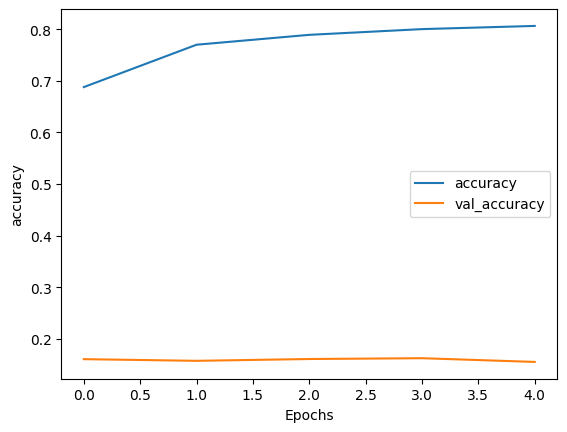

In [102]:
plot_graphs(history, 'accuracy')

In [54]:
def sentence_convert_data(data):
    global bert_tokenizer
    tokens , masks , segment = [],[],[]
    input_id , attention_mask , token_type_id = bert_tokenizer(data , MAX_LEN)

    tokens.append(input_id)
    masks.append(attention_mask)
    segment.append(token_type_id)

    tokens = np.array(tokens,dtype=int)
    masks = np.array(masks,dtype=int)
    segments = np.array(segment,dtype=int)

    return [tokens,masks,segments]

In [120]:
# 모델을 SavedModel 형식으로 저장
sentiment_model.save_weights("/content/best_model_1128_adamw_10epochs_ver2.h5")

# **모델 가중치 로드 후 예측함수 생성**

In [121]:
import tensorflow as tf
import pandas as pd
import numpy as np
from transformers import TFBertModel, BertTokenizer

# BERT 토크나이저와 모델 로드
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = TFBertModel.from_pretrained('bert-base-multilingual-cased')

# KOBERT
# tokenizer = AutoTokenizer.from_pretrained("Definite/kobert-finetuned-klue-ner-finetuned-bible")
# bert_model = TFBertModel.from_pretrained('Definite/kobert-finetuned-klue-ner-finetuned-bible')

MAX_LEN = 50

def bert_tokenizer(sent, MAX_LEN):

    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
        max_length = MAX_LEN,           # Pad & truncate all sentences.
        pad_to_max_length = True,
        return_attention_mask = True   # Construct attn. masks.

    )

    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask'] # And its attention mask (simply differentiates padding from non-padding).
    token_type_id = encoded_dict['token_type_ids'] # differentiate two sentences

    return input_id, attention_mask, token_type_id


# # 사용자 정의 모델 정의
# class CustomBERTModel(tf.keras.Model):
#     def __init__(self, num_classes):
#         super(CustomBERTModel, self).__init__()
#         self.bert = bert_model
#         # 추가적인 레이어는 필요에 따라 정의
#         self.dropout = tf.keras.layers.Dropout(0.1)  # 예시로 dropout 레이어 추가
#         # 추가 중간 밀집 레이어
#         self.dense1 = tf.keras.layers.Dense(units=128, activation='relu')
#         # 배치 정규화 레이어
#         self.batch_norm = tf.keras.layers.BatchNormalization()
#         # 추가 드롭아웃 레이어
#         self.dropout2 = tf.keras.layers.Dropout(rate=0.5)
#         self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

#     def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
#         # BERT 모델의 출력을 가져옵니다.
#         outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
#         sequence_output = outputs[0]
#         pooled_output = outputs[1]
#         # 드롭아웃 적용
#         pooled_output = self.dropout(pooled_output, training=training)

#         # 추가 중간 밀집 레이어 적용
#         middle_output = self.dense1(pooled_output)

#         # 배치 정규화 적용
#         middle_output = self.batch_norm(middle_output, training=training)

#         # 추가 드롭아웃 적용
#         middle_output = self.dropout2(middle_output, training=training)

#         # 최종 분류기 레이어를 통한 로짓
#         return self.classifier(middle_output)


# 사용자 정의 모델 정의
class CustomBERTModel(tf.keras.Model):
    def __init__(self, num_classes):
        super(CustomBERTModel, self).__init__()
        self.bert = bert_model
        # 추가적인 레이어는 필요에 따라 정의
        self.dropout = tf.keras.layers.Dropout(0.1)  # 예시로 dropout 레이어 추가
        self.classifier = tf.keras.layers.Dense(num_classes, activation='softmax')

    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        # BERT 모델의 출력을 가져옵니다.
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        pooled_output = outputs.pooler_output
        pooled_output = self.dropout(pooled_output, training=training)
        return self.classifier(pooled_output)


# 클래스 개수
model = CustomBERTModel(6)

# 모델에 적절한 입력 데이터 제공하여 내부 구조 초기화
test_input = tokenizer.encode_plus("테스트 문장", return_tensors='tf', padding='max_length', max_length=128, truncation=True)
model(test_input['input_ids'], attention_mask=test_input['attention_mask'], token_type_ids=test_input['token_type_ids'])

# 가중치 로드
model.load_weights('/content/best_model_1128_adamw_10epochs_ver2.h5')

def sentence_convert_data(data):
    global bert_tokenizer
    tokens , masks , segment = [],[],[]
    input_id , attention_mask , token_type_id = bert_tokenizer(data , MAX_LEN)
    tokens.append(input_id)
    masks.append(attention_mask)
    segment.append(token_type_id)
    tokens = np.array(tokens,dtype=int)
    masks = np.array(masks,dtype=int)
    segments = np.array(segment,dtype=int)
    return [tokens,masks,segments]



def lyrics_evaluation_predict(sentence):
    data_x = sentence_convert_data(sentence)  # 문장을 모델 입력 형식으로 변환
    predict = model.predict(data_x)
    predict_value = np.ravel(predict[0])
    # 예측된 클래스의 인덱스를 찾기.

    predicted_class = np.argmax(predict_value)
    if predicted_class == 0:
        print("(기쁨 확률: {:.2f}) 기쁨을 나타내는 문장입니다.".format(predict_value[predicted_class]))
    elif predicted_class == 1:
        print("(사랑 확률: {:.2f}) 사랑을 나타내는 문장입니다.".format(predict_value[predicted_class]))
    elif predicted_class == 2:
        print("(슬픔 확률: {:.2f}) 슬픔을 나타내는 문장입니다.".format(predict_value[predicted_class]))
    elif predicted_class == 3:
        print("(분노 확률: {:.2f} 분노를 나타내는 문장입니다.)".format(predict_value[predicted_class]))
    elif predicted_class == 4:
        print("(걱정 확률: {:.2f} 걱정을 나타내는 문장입니다.)".format(predict_value[predicted_class]))
    elif predicted_class == 5:
        print("(중립 확률: {:.2f} 중립을 나타내는 문장입니다.)".format(predict_value[predicted_class]))

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

# 텍스트로 예측

In [160]:
lyrics_evaluation_predict('''
오늘은 여자친구와의 갈등으로 불편한 감정을 안고 하루를 보냈다.
처음에는 작은 의견 차이였는데, 예상치 못한 갈등으로 번지면서 상황이 급격하게 악화되었다.
언쟁이 시작되자 마음은 답답함과 무력감으로 가득 찼다.
서로를 이해하지 못한 채 말다툼이 이어지니 마치 작은 불씨에서 큰 불길이 번져나가는 듯한 느낌이었다.
평소에는 서로에게 편안함과 지지를 주던 관계가 갑자기 낯선 감정으로 가득차니 마음이 무겁다.
그래도 우리는 서로에게 솔직하게 말하고 이해하려고 노력하고 있다.
오늘의 갈등은 미묘한 감정의 교차와 상처가 남아서 쉽게 풀릴 것 같지 않다.
하지만 더 나은 소통과 이해를 위해 노력하는 것이 중요하다는 것을 다시 한번 느꼈다.
내일은 좀 더 평화로운 하루가 되기를 바란다.
''')

1/1 [==============================] - 0s 44ms/step
(슬픔 확률: 0.58) 슬픔을 나타내는 문장입니다.


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [161]:
lyrics_evaluation_predict('''
이제 곧 새해다
새해가 되면
금연하고
여자친구도 만들고
다이어트 20kg 감량 성공하고
취업도 하고
옷도 이쁜걸로 많이  사고
맛있는거 많이 사먹고
집도 사고
차도 사고
다해야징''')

1/1 [==============================] - 0s 40ms/step
(기쁨 확률: 0.93) 기쁨을 나타내는 문장입니다.


In [162]:
lyrics_evaluation_predict('''나 윤이현 티어는 골든인데
진짜 할때마다 팀운이 개구려서 플레티넘에 갈수가 없다ㅡㅡ
리얼 나는 잠재적 에메랄드티어인데''')

1/1 [==============================] - 0s 38ms/step
(분노 확률: 0.50 분노를 나타내는 문장입니다.)


In [163]:
lyrics_evaluation_predict('''
"기생충"은 감독 봉준호의 작품으로, 독특한 스토리와 뛰어난 연출로 큰 주목을 받은 작품이다.
이 영화는 사회적 계층과 간격을 다루면서 풍부한 메타포와 비판적 시선을 제시한다.
영화의 강점 중 하나는 캐릭터의 복잡한 심리와 행동을 통해 사회적 메시지를 전달하는 데에 있다.
가난과 부의 대립, 상류층과 하류층의 갈등을 통해 현실적이면서도 은유적인 이야기를 풀어내어 관객에게 깊은 여운을 남긴다.
또한, "기생충"은 전개와 엔딩이 예측 불허하는 스릴러적인 요소를 가지고 있다.
특히, 중간에 펼쳐지는 전환점들이 관객을 더욱 흥미진진하게 만들어준다.
배우들의 연기도 훌륭하며, 감독의 섬세한 연출이 이야기를 효과적으로 전달한다.
이 작품은 단순한 엔터테인먼트를 넘어 사회적인 문제에 대한 생각을 불러일으키는 작품으로, 현대 사회의 불평등과 부조리에 대한 메시지를 전달하며 깊은 여운을 남긴다.
"기생충"은 그야말로 현대예술의 진수를 보여주는 작품 중 하나로 꼽힌다.
결론: ㄹㅇ 띵작
다들 봤으면 한다
너무 재밌었다. 또 보러가야징
''')

1/1 [==============================] - 0s 39ms/step
(기쁨 확률: 0.90) 기쁨을 나타내는 문장입니다.


In [164]:
lyrics_evaluation_predict('''
Oh 너가 없는 날 oh
바보같이 난 오늘도
널 떠올리는 중이야 oh yeah
아픈 너의 맘을 oh oh
안아줄 수는 없어도
난 지금 생각 중이야 oh oh
너에게 난 부족한 사람
늘 모자란 사람
나의 예감은
나에게 넌 어려운 사람
참 아까운 사람
상처 많은 참 못났던 사람
널 울리고서
다신 안 볼 것처럼
널 밀어내고
그땐 뭐가 그리 힘들었는지
떠나버린 사랑에
아쉬운 밤을 보네
네가 떠난 날
다신 없을 걸 아는데
널 기다리는 중이야 oh oh
사랑했던 날
함께한 시간들이 날
괴롭히는 중이야 oh oh
너에게 난 부족한 사람
늘 모자란 사람
네 맘도 모르던 사람
나에게 넌 어려운 사람
참 아쉬운 사람
상처만 주고 떠나요
참 못났던 사람
널 울리고서 다신 안 볼 것처럼
널 밀어내고
그땐 뭐가 그리 힘들었는지
떠나버린 사랑에
아쉬운 밤을 보네
참 못났던 사람
널 울리고서
다신 안 볼 것처럼
널 밀어내고
그땐 뭐가 그리 힘들었는지
떠나버린 사랑에
아쉬운 밤을 보네
''')

1/1 [==============================] - 0s 41ms/step
(슬픔 확률: 0.67) 슬픔을 나타내는 문장입니다.


In [165]:
lyrics_evaluation_predict("사랑해 너를 사랑해 죽을만큼 힘이 들지만")

1/1 [==============================] - 0s 39ms/step
(사랑 확률: 0.95) 사랑을 나타내는 문장입니다.


In [166]:
lyrics_evaluation_predict("너 답이없다 참")

1/1 [==============================] - 0s 40ms/step
(분노 확률: 0.87 분노를 나타내는 문장입니다.)


In [167]:
lyrics_evaluation_predict("만남은 쉽고 이별은 어려워")

1/1 [==============================] - 0s 40ms/step
(슬픔 확률: 0.86) 슬픔을 나타내는 문장입니다.


In [168]:
lyrics_evaluation_predict("만남의 기쁨도 이별의 슬픔도")

1/1 [==============================] - 0s 41ms/step
(슬픔 확률: 0.97) 슬픔을 나타내는 문장입니다.


In [172]:
lyrics_evaluation_predict("가까이 있는 널 잡지 못해")

1/1 [==============================] - 0s 41ms/step
(슬픔 확률: 0.79) 슬픔을 나타내는 문장입니다.


In [189]:
lyrics_evaluation_predict("호감있는 여자애가 있어")

1/1 [==============================] - 0s 40ms/step
(사랑 확률: 0.92) 사랑을 나타내는 문장입니다.


In [179]:
lyrics_evaluation_predict("너 아니면 나 못해")

1/1 [==============================] - 0s 42ms/step
(슬픔 확률: 0.56) 슬픔을 나타내는 문장입니다.


In [174]:
lyrics_evaluation_predict("참 서툴고 어설픈 나지만")

1/1 [==============================] - 0s 39ms/step
(슬픔 확률: 0.59) 슬픔을 나타내는 문장입니다.


## 추가학습

### 추가 학습할 데이터 불러오기

In [ ]:
more_data = pd.read_csv("/content/1117사랑분노데이터.csv")

In [ ]:
# more_data = more_data.drop("Unnamed: 0", axis=1)
more_data = more_data.dropna()

### 추가학습 코드

In [ ]:
# 가중치 로드
model.load_weights('/content/1117_saved_model_10epoch.h5')


def prepare_data(data):
    input_ids, attention_masks, token_type_ids, labels = [], [], [], []

    for _, row in data.iterrows():
        sentence = row['Dalogue_stopwords']
        label = row['Emotion']
        input_id, attention_mask, token_type_id = bert_tokenizer(sentence, MAX_LEN)

        input_ids.append(input_id)
        attention_masks.append(attention_mask)
        token_type_ids.append(token_type_id)
        labels.append(label)

    return np.array(input_ids), np.array(attention_masks), np.array(token_type_ids), np.array(labels)

input_ids, attention_masks, token_type_ids, labels = prepare_data(more_data)

opt = tfa.optimizers.RectifiedAdam(lr=1e-5, total_steps = 64, warmup_proportion=0.1, min_lr=1e-5, epsilon=1e-08, clipnorm=1.0)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

history = model.fit(
    [input_ids, attention_masks, token_type_ids],
    labels,
    validation_split=0.3,
    batch_size=128,
    epochs=5
)

Epoch 1/5
1/1 [==============================] - 41s 41s/step - loss: 2.8762 - accuracy: 0.3306 - val_loss: 0.3050 - val_accuracy: 0.8868
Epoch 2/5
1/1 [==============================] - 6s 6s/step - loss: 2.9640 - accuracy: 0.3388 - val_loss: 0.3051 - val_accuracy: 0.8868
Epoch 3/5
1/1 [==============================] - 6s 6s/step - loss: 2.9747 - accuracy: 0.3223 - val_loss: 0.3052 - val_accuracy: 0.8868
Epoch 4/5
1/1 [==============================] - 6s 6s/step - loss: 2.9238 - accuracy: 0.2975 - val_loss: 0.3055 - val_accuracy: 0.8868
Epoch 5/5
1/1 [==============================] - 6s 6s/step - loss: 2.7930 - accuracy: 0.3471 - val_loss: 0.3057 - val_accuracy: 0.8868


In [ ]:
# 추가학습 예측성능 확인하기
def predict(sentence):
    data_x = sentence_convert_data(sentence)
    predict = model.predict(data_x)
    predict_value = np.ravel(predict[0])
    predicted_class = np.argmax(predict_value)
    return predicted_class, predict_value[predicted_class]

sentence =  "짝남이랑 데이트"
predicted_class, confidence = predict(sentence)
print(f"감정: {predicted_class}, 확률: {confidence}")

1/1 [==============================] - 0s 114ms/step
감정: 2, 확률: 0.5108464360237122
